# RiceLeaf disease detection

## INTRODUCTION
The rice leaf suffers from several bacterial, viral, or fungal diseases and these diseases reduce rice production significantly. To sustain rice demand for a vast population globally.The rice leaves related diseases often pose threats to the sustainable production of rice affecting many farmers around the world. Early diagnosis and appropriate remedy of the rice leaf infection is crucial in facilitating healthy growth of the rice plants to ensure adequate supply and food security to the rapidly increasing population.
### RICE LEAF DISEASE:
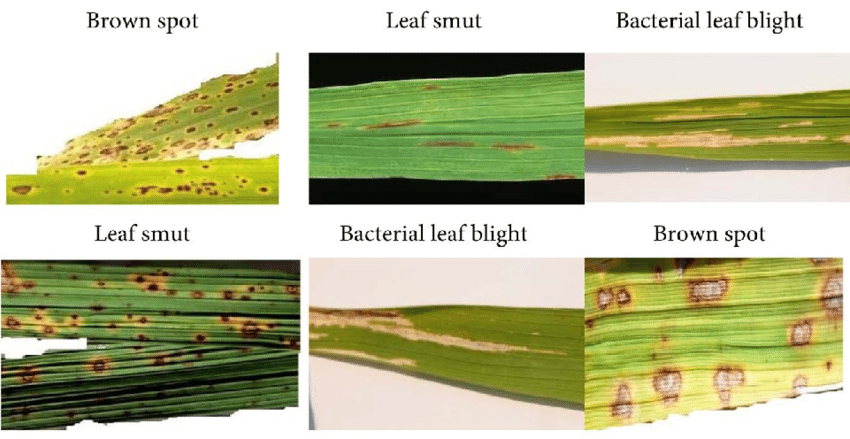

### WE HAVE DIVIDE THE PROJECT INTO MULTIPLE STEPS
* Importing library
* Loading data
* Visualization
* Normalization 
* Model creation and compiling
* Training
* Fetching
* Plotting accuracy (training & validation)
* Evaluation & Testing

### DATA SUMMARY
This dataset contains 120 jpg images of disease infected rice leaves. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class.

Classes

* Leaf smut
* Brown spot
* Bacterial leaf blight

## IMPORTING NECESSARY LIBRARIES 

In [1]:
import numpy as np
import tensorflow as tf
import os
import shutil
import random
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense



In [2]:
# Define the source folder (where your class folders are) and the target folders
source_dir = 'Data'  # Original data with class folders
target_dir = './split_data'  # New directory for train/validation/test splits

# Split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Create train, validation, and test folders
for split in ['train', 'validation', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

# Split the data
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name}")  # Debugging: List all classes being processed

    # Get all file names for the current class
    filenames = [f for f in os.listdir(class_path) if not f.startswith('.')]  # Exclude hidden files
    random.shuffle(filenames)  # Shuffle to ensure randomness

    # Determine split indices
    total = len(filenames)
    train_end = int(train_ratio * total)
    valid_end = train_end + int(validation_ratio * total)

    # Assign files to each split
    train_files = filenames[:train_end]
    valid_files = filenames[train_end:valid_end]
    test_files = filenames[valid_end:]

    # Print stats for the class
    print(f"Class '{class_name}': {total} total images")
    print(f"Train: {len(train_files)}, Validation: {len(valid_files)}, Test: {len(test_files)}")

    # Copy files to respective folders
    for file_list, split in zip([train_files, valid_files, test_files], ['train', 'validation', 'test']):
        for file in file_list:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(target_dir, split, class_name, file)
            shutil.copy(src_path, dst_path)

print("Data successfully split into train, validation, and test sets!")


Processing class: Bacterial leaf blight
Class 'Bacterial leaf blight': 40 total images
Train: 28, Validation: 6, Test: 6
Processing class: Brown spot
Class 'Brown spot': 40 total images
Train: 28, Validation: 6, Test: 6
Processing class: Leaf smut
Class 'Leaf smut': 39 total images
Train: 27, Validation: 5, Test: 7
Data successfully split into train, validation, and test sets!


## DATASET PATHS AND LOAD DATASETS

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = 'split_data/train'
validation_dir = 'split_data/validation'


# Generating batches of image data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= (1./255),
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=(1./255))

train_data = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32,
    color_mode='rgb',
    label_mode='categorical'

)

validation_data = image_dataset_from_directory(
    validation_dir,
    image_size=(150,150),
    batch_size=32,
    color_mode='rgb',
    label_mode='categorical'
)


# Optional: Class names from the dataset
class_names = train_data.class_names
print("Class names:", class_names)


Found 119 files belonging to 3 classes.
Found 95 files belonging to 3 classes.
Class names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [4]:
# Set a seed for reproducibility
seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Ensure reproducibility in TensorFlow
os.environ['PYTHONHASHSEED'] = str(seed)  # Python hash seed

os.environ['TF_DETERMINISTIC_OPS'] = '1'





## VISUALISE THE DATA

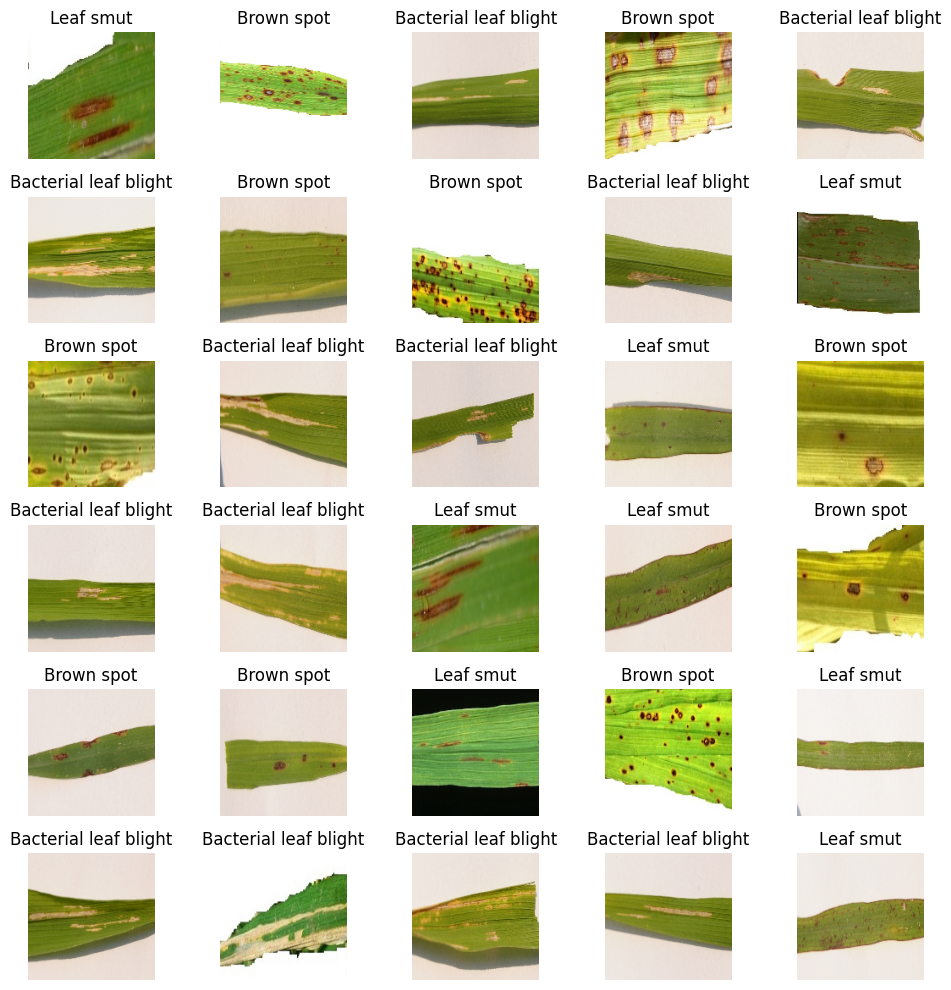

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(30):  # Show 25 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        # Get the class index from the one-hot encoded labels
        class_idx = np.argmax(labels[i].numpy())  # Convert to class index
        plt.title(class_names[class_idx])
        
        plt.axis('off')
    plt.tight_layout()
plt.show()


## NORMALISE THE VALUES

In [6]:
train_data = train_data.map(lambda x, y: (x / 255.0, y))
validation_data = validation_data.map(lambda x, y: (x / 255.0, y))

In [7]:
validation_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

* Normalization: Scale pixel values to a range [0, 1] by dividing by 255.

In [8]:
print(len(validation_data))

3


## CREATE MODEL

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',input_shape=(150, 150, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=128 , kernel_size=3 ,padding='same' ,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=256 , kernel_size=3 ,padding='same' ,activation='relu'))
model.add(MaxPooling2D())

model.add(Dense(units=128, activation='relu', input_dim=784))  # First dense layer with 128 neurons
model.add(Flatten())
model.add(Dropout(0.3))  # Dropout layer with 30% dropout
model.add(Dense(units=64, activation='relu'))  # Second dense layer with 64 neurons
model.add(Dropout(0.3))  # Dropout layer with 30% dropout
model.add(Dense(units=3, activation='softmax'))  # Output layer for 10 classes


model.summary()

C:\Users\Saurav Mahale\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Saurav Mahale\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4, 4, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,835 (2.12 MB)

 Trainable params: 556,835 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

## COMPILE THE MODEL

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




## TRAIN MODEL

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5.keras', monitor='val_loss', save_best_only=True)
]


history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=40  # Adjust the number of epochs as needed
    
)


Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.3765 - loss: 1.0973 - val_accuracy: 0.3263 - val_loss: 1.0977
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.3316 - loss: 1.1131 - val_accuracy: 0.3579 - val_loss: 1.0931
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.3048 - loss: 1.1053 - val_accuracy: 0.3579 - val_loss: 1.0921
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.3292 - loss: 1.1025 - val_accuracy: 0.3895 - val_loss: 1.0911
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.3371 - loss: 1.0924 - val_accuracy: 0.4211 - val_loss: 1.0867
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.3511 - loss: 1.0869 - val_accuracy: 0.4632 - val_loss: 1.0785
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.4308 - loss: 1.0803 - val_accuracy: 0.4632 - val_loss: 1.0572
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.4768 - loss: 1.0553 - val_accuracy: 0.5053 - val_loss:

In [12]:
model.save("model.h5.keras")

## FETCH A BATCH OF DATA FROM THE VALIDATION DATASET

In [13]:
print(f"Number of images in batch: {len(images)}")

Number of images in batch: 32


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


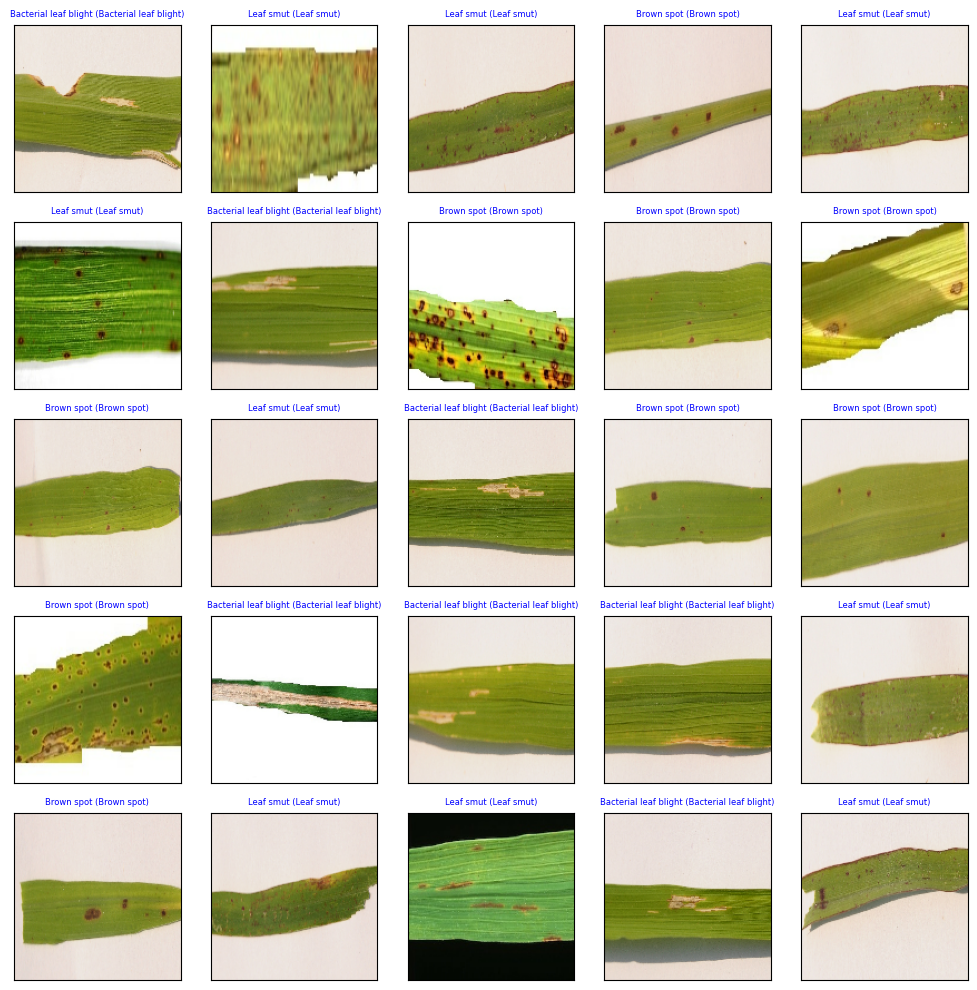

In [14]:
for images, labels in validation_data.take(1):
    # Get model predictions for the batch
    y_pred = model.predict(images)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
    #y_true = labels.numpy()  # Convert labels to NumPy array
   
    y_true = np.argmax(labels.numpy(), axis=1)
    
    # Plot 25 random images from the batch
    fig = plt.figure(figsize=(10, 10))
    for i, idx in enumerate(np.random.choice(len(images), size=25, replace=False)):
        ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
        ax.imshow((images[idx].numpy()*255).astype('uint8'))  # Display the image

        # Get the predicted and true labels
        pred_label = class_names[y_pred_classes[idx]]
        true_label = class_names[y_true[idx]]

        # Set the title with color indicating correct or incorrect prediction
        ax.set_title(f"{pred_label} ({true_label})",
                     color=("blue" if pred_label == true_label else "red"),fontsize=6)

    plt.tight_layout()
    plt.show()

## PLOT TRAINING AND VALIDATION ACCURACY

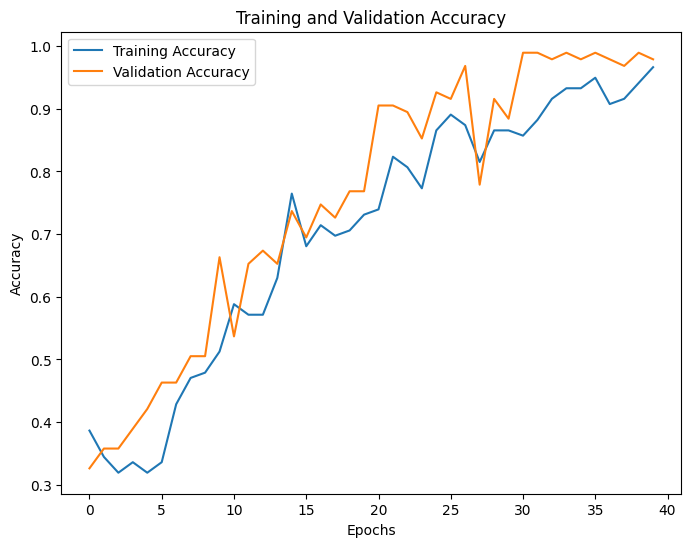

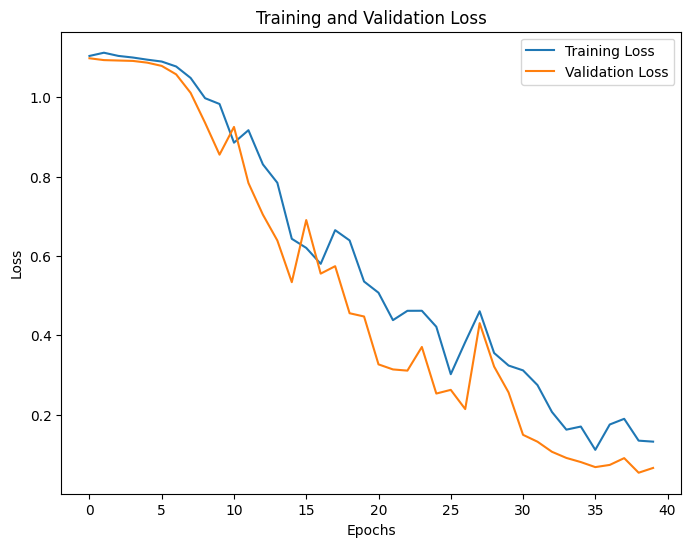

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [16]:
val_loss, val_accuracy = model.evaluate(validation_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy*100}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9856 - loss: 0.0604
Validation Loss: 0.06609869003295898
Validation Accuracy: 97.89473414421082


### AFTER TRAINING
* Validation accuracy : 97.87%
* Training accuracy : 97.51%

In [17]:
model = tf.keras.models.load_model("model.h5.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4, 4, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,670,507 (6.37 MB)

 Trainable params: 556,835 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,113,672 (4.25 MB)

## EVALUATION AND TESTING MODEL

In [18]:
test_dir='split_data/test'
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=(1./255))

test_data = image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    batch_size=32,
    color_mode='rgb',
    label_mode='categorical'
)

Found 98 files belonging to 3 classes.


In [19]:
model.evaluate(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9659 - loss: 7.0635 


[5.7301154136657715, 0.9693877696990967]

### AFTER TESTING
* Here the loss is 5.73 and the accuracy of the model is 0.9693 percent means 96%.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


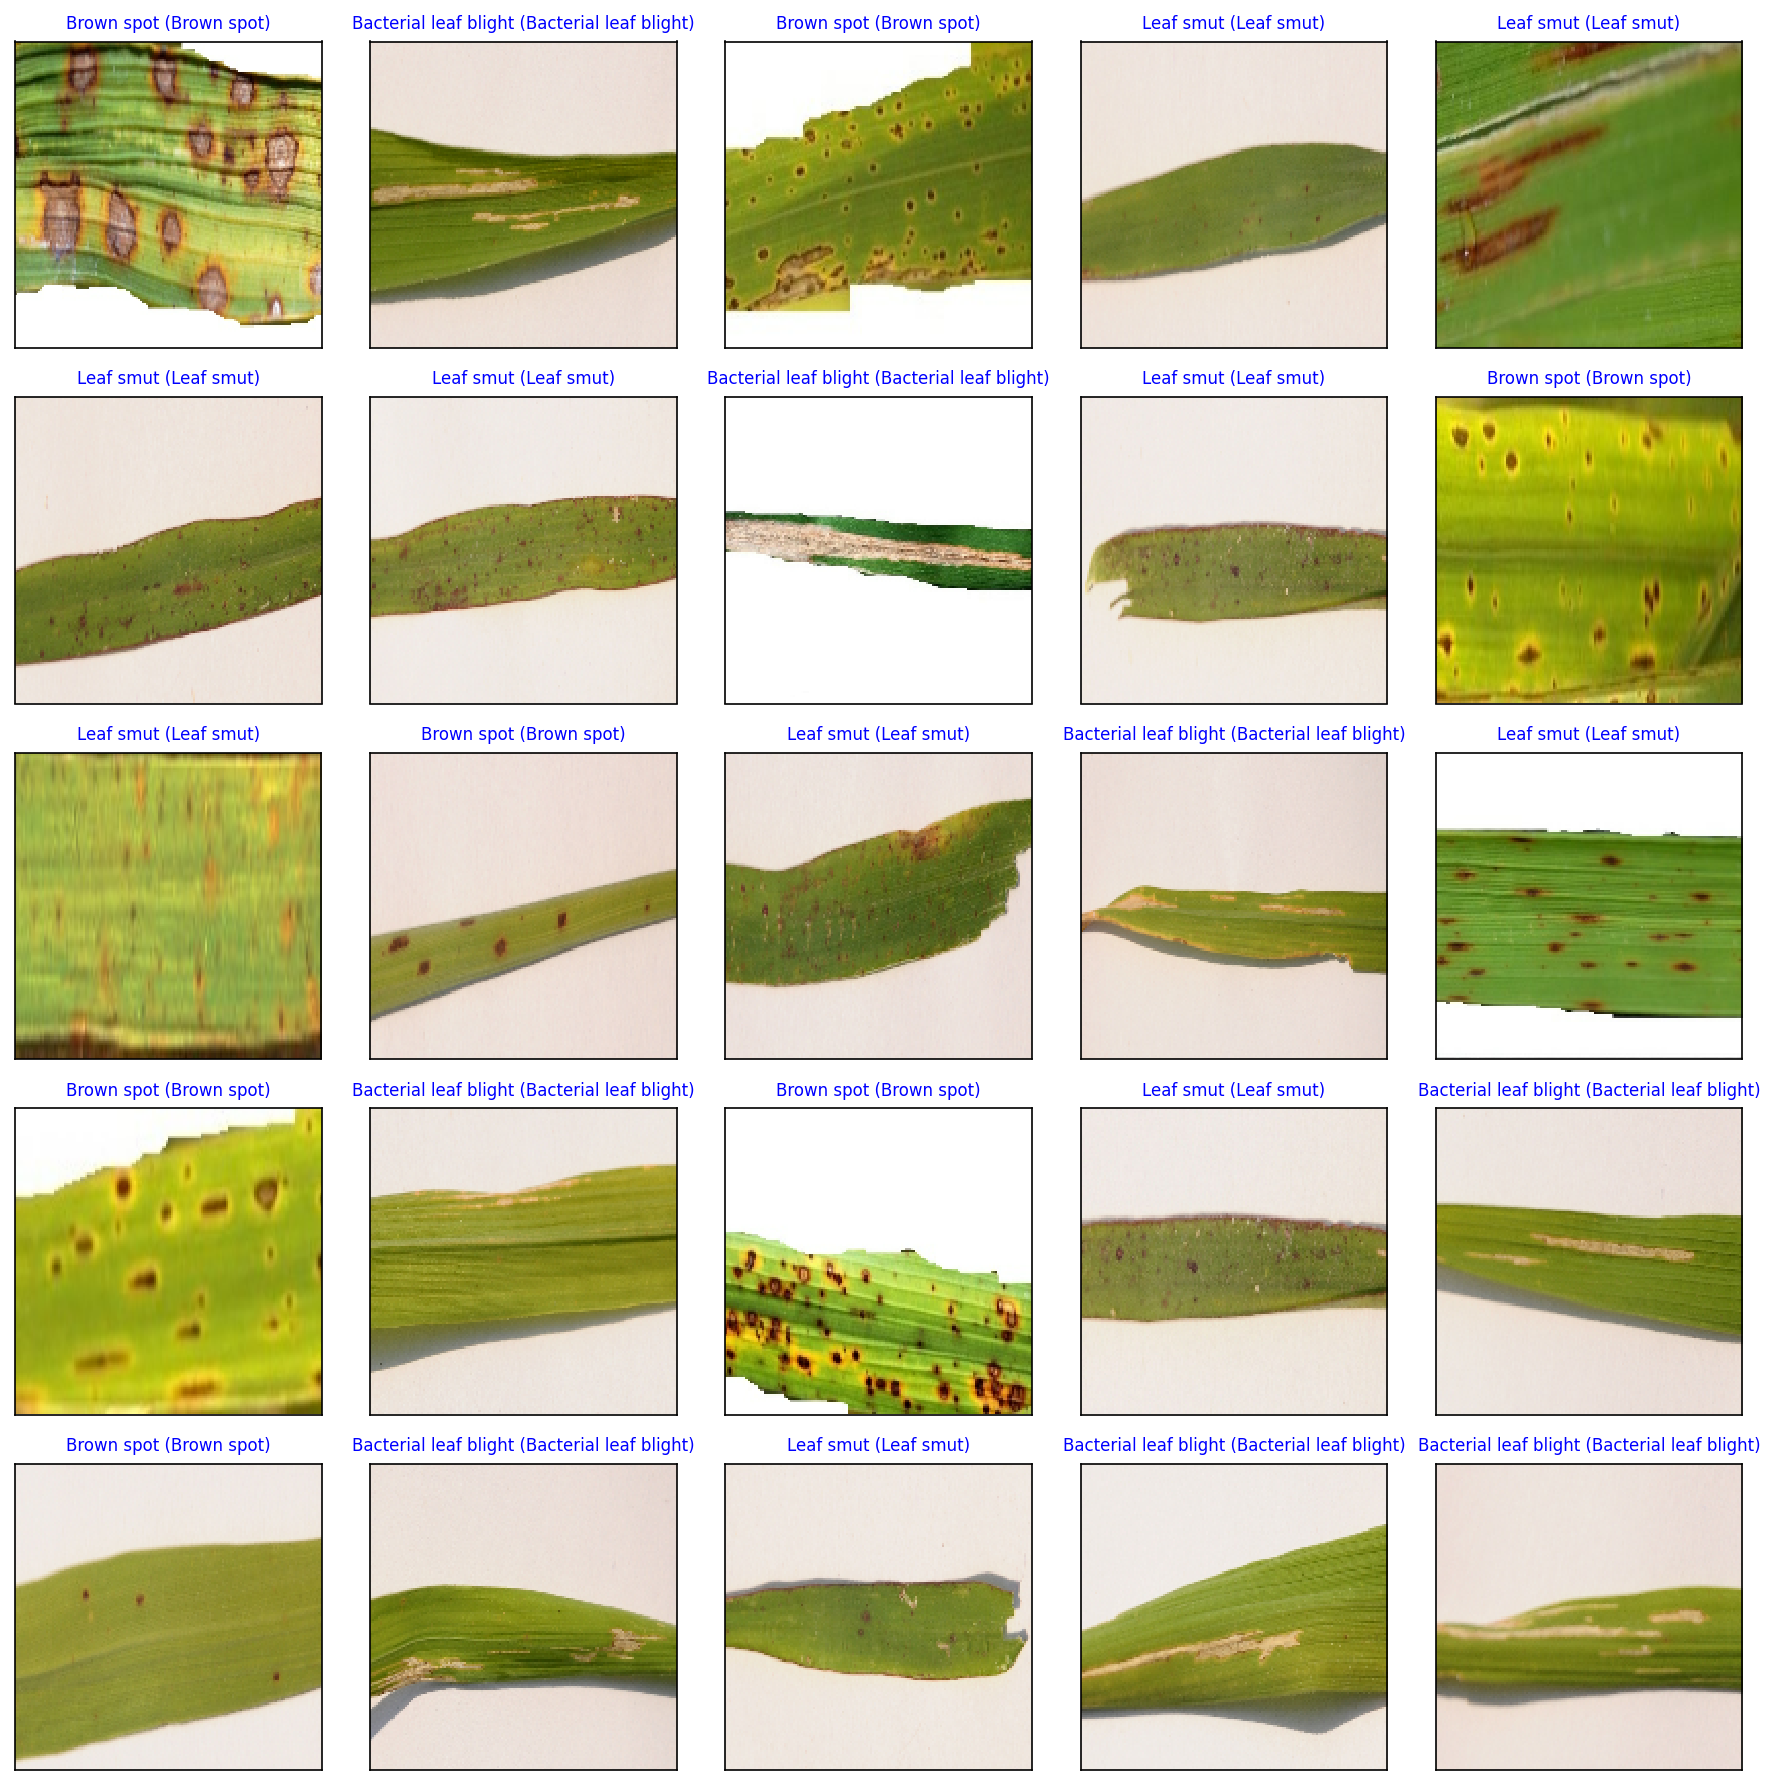

In [20]:
for images, labels in test_data.take(1):
    y_pred = model.predict(images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(labels.numpy(), axis=1)
    
    # Plot 25 random images from the batch
    fig = plt.figure(figsize=(12, 12), dpi=150)
    for i, idx in enumerate(np.random.choice(len(images), size=25, replace=False)):
        ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
        
        # Process the image
        image = images[idx].numpy()  # Convert to NumPy
        if image.max() <= 1.0:  # Check if the image is normalized
            image = (image * 255).astype('uint8')  # Scale to 0-255
        else:
            image = image.astype('uint8')  # Cast to uint8
        
        # Ensure dimensions are correct
        if image.shape[-1] != 3:  # Ensure RGB format
            image = np.stack([image.squeeze()] * 3, axis=-1)  # Convert grayscale to RGB
        
        ax.imshow(image, interpolation='nearest')  # Display the image
        
        # Get the predicted and true labels
        pred_label = class_names[y_pred_classes[idx]]
        true_label = class_names[y_true[idx]]
        
        # Set the title with color indicating correct or incorrect prediction
        ax.set_title(f"{pred_label} ({true_label})",
                     color=("blue" if pred_label == true_label else "red"),
                     fontsize=8)
    
    plt.tight_layout()
    plt.show()


## CHALLENGES

* Data Imbalance: Some diseases may have fewer images in the dataset, requiring balancing techniques like oversampling or using weighted loss functions.

* Model Generalization: Ensure that the model generalizes well to new, unseen images. This can be achieved by using techniques like dropout, regularization, and validation during training.

## Potential Impact:

* Precision Agriculture: The model can help farmers detect diseases early, reducing crop losses and the need for excessive pesticide use.

* Automation: Automating rice disease diagnosis can improve efficiency in large-scale farming, especially in regions where experts are not readily available.

## CONCLUSION

The RiceLeaf disease detection CNN model is a promising tool for enhancing agricultural practices by providing an automated, efficient, and accurate way to identify diseases in rice crops. This project demonstrates the immense potential of deep learning in precision agriculture, with the capacity to improve food security and sustainability in rice-producing regions globally.